In [21]:
import yfinance as yf # Import Yahoo Finance library
import pandas as pd # Import Pandas for data manipulation
import os # For checking if a file exists
import matplotlib.pyplot as plt # For plotting

In [19]:
# Check if S&P 500 data is already downloaded
if os.path.exists("sp500(1).csv"):
    sp500 = pd.read_csv("sp500(1).csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500(1).csv")

In [9]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-09-11 00:00:00-04:00,4480.979980,4490.770020,4467.890137,4487.459961,3369920000,0.0,0.0
2023-09-12 00:00:00-04:00,4473.270020,4487.109863,4456.830078,4461.899902,3435740000,0.0,0.0
2023-09-13 00:00:00-04:00,4462.649902,4479.390137,4453.520020,4467.439941,3529430000,0.0,0.0


In [17]:
# Convert the index to datetime format for time-series analysis
sp500.index = pd.to_datetime(sp500.index)

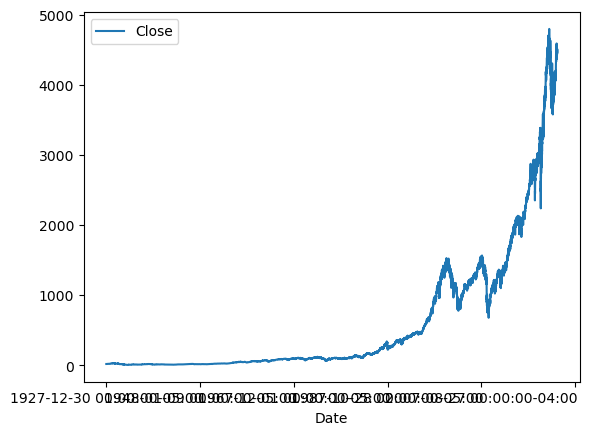

In [22]:
# Plot the 'Close' prices
sp500.plot.line(y="Close", use_index=True)
plt.show()

In [23]:
# Delete the 'Dividends' and 'Stock Splits' columns
del sp500["Dividends"]
del sp500["Stock Splits"]

In [24]:
# Add a Tomorrow column that shifts the Close column up by one
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [25]:
# Add a Target column: 1 if price increases next day, 0 otherwise
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [26]:
# Filter data to use only data from 1990 onwards
sp500 = sp500.loc["1990-01-01":].copy()

In [27]:
from sklearn.ensemble import RandomForestClassifier # Import Random Forest Classifier
# Initialize the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
# Create training and test datasets
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]
# Define predictors
predictors = ["Close", "Volume", "Open", "High", "Low"]
# Train the model
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [28]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5352112676056338

<AxesSubplot:xlabel='Date'>

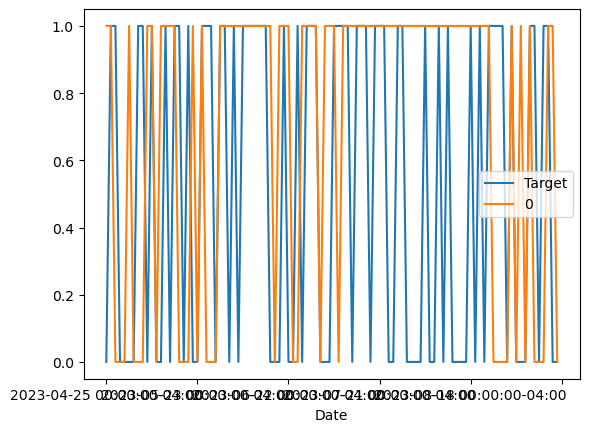

In [29]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [31]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [32]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [33]:
predictions = backtest(sp500, model, predictors)

In [34]:
predictions["Predictions"].value_counts()

0    3436
1    2556
Name: Predictions, dtype: int64

In [35]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5289514866979655

In [36]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.533712
0    0.466288
Name: Target, dtype: float64

In [37]:
predictions

,Target,Predictions
Date,,
1999-11-22 00:00:00-05:00,0,0
1999-11-23 00:00:00-05:00,1,0
1999-11-24 00:00:00-05:00,0,0
1999-11-26 00:00:00-05:00,0,0
1999-11-29 00:00:00-05:00,0,0
...,...,...
2023-09-11 00:00:00-04:00,0,1
2023-09-12 00:00:00-04:00,1,1
2023-09-13 00:00:00-04:00,1,1
